In [3]:
import torch 

import random

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from torch.utils.data import DataLoader


/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <4C793A59-B32A-3AF1-BEA5-03AD7C5C80C6> /opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/masterxdl/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/masterxdl/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you 

1. Set up CIFAR-10 Datasets and Loaders

In [4]:
# Data transformations (Normalization is important)

transform = transforms.Compose([

    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Mean and std deviation for 3 channels
])

# Load the CIFAR-10 Dataset

train_dataset = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)

test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
class CustomNN(nn.Module):

    def __init__(self):
        super(CustomNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2,2)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128  * 8 * 8 , 256)

        self.fc2 = nn.Linear( 256 , 10) # CIFAR-10 has 10 classes


    def forward(self,x):

        x = F.relu(self.conv1(x))

        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))


        x = x.view(x.size(0), -1) # Flatten

        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x

Create Model Instance and Set Device(MPS FOR MAC)

In [6]:
# Use MPS if available (for Apple Silicon Macbook)

device  = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')

print(f'Using Device :{device}')

model = CustomNN().to(device)

Using Device :mps


Set loss function and optimizer

In [7]:
# Loss and  optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=0.001)

Train for 10 epochs increase it later

In [8]:
num_epochs = 10


train_losses = []

test_losses = []

train_accuracies = []

test_accuracies = []


for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    correct = 0

    total = 0


    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()


        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)

        correct += predicted.eq(labels).sum().item()



    train_loss = running_loss / len(train_loader)

    train_acc = 100. * correct / total

    train_losses.append(train_loss)

    train_accuracies.append(train_acc)


    # Evaluation phase

    model.eval()

    test_loss = 0.0

    correct = 0

    total = 0


    with torch.no_grad():

        for input, labels in test_loader:

            input, labels = input.to(device), labels.to(device)


            outputs = model(input)

            loss = criterion(outputs, labels)


            test_loss += loss.item()

            _, predicted = outputs.max(1)

            total += labels.size(0)

            correct += predicted.eq(labels).sum().item()

    
    test_loss /= len(test_loader)

    test_acc = 100. * correct / total

    test_losses.append(test_loss)

    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}] -> Train Loss : {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% ')

Epoch [1/10] -> Train Loss : 1.2455, Train Acc: 55.19%, Test Loss: 0.9512, Test Acc: 65.93% 
Epoch [2/10] -> Train Loss : 0.7925, Train Acc: 72.23%, Test Loss: 0.7968, Test Acc: 72.19% 
Epoch [3/10] -> Train Loss : 0.5677, Train Acc: 80.09%, Test Loss: 0.7399, Test Acc: 75.33% 
Epoch [4/10] -> Train Loss : 0.3824, Train Acc: 86.56%, Test Loss: 0.7776, Test Acc: 74.55% 
Epoch [5/10] -> Train Loss : 0.2239, Train Acc: 92.17%, Test Loss: 0.9448, Test Acc: 75.24% 
Epoch [6/10] -> Train Loss : 0.1300, Train Acc: 95.42%, Test Loss: 1.1065, Test Acc: 74.95% 
Epoch [7/10] -> Train Loss : 0.0929, Train Acc: 96.73%, Test Loss: 1.2856, Test Acc: 75.19% 
Epoch [8/10] -> Train Loss : 0.0804, Train Acc: 97.23%, Test Loss: 1.3668, Test Acc: 74.98% 
Epoch [9/10] -> Train Loss : 0.0685, Train Acc: 97.71%, Test Loss: 1.4406, Test Acc: 74.02% 
Epoch [10/10] -> Train Loss : 0.0598, Train Acc: 98.00%, Test Loss: 1.5664, Test Acc: 75.39% 


Plot loss and accuracy curves

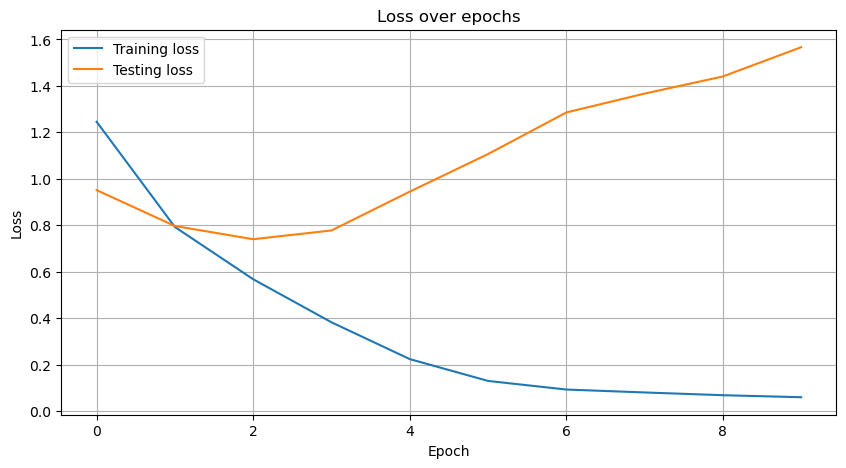

In [9]:
# Plotting loss

plt.figure(figsize=(10,5))

plt.plot(train_losses, label= 'Training loss')

plt.plot(test_losses, label= 'Testing loss')

plt.title('Loss over epochs')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.grid(True)

plt.show()

Plot Training and testing accuracy curves

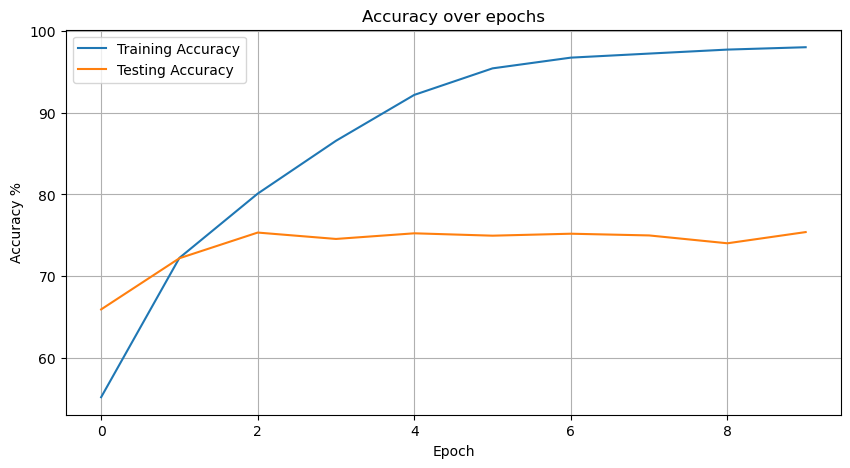

In [10]:
# Plotting loss

plt.figure(figsize=(10,5))

plt.plot(train_accuracies, label= 'Training Accuracy')

plt.plot(test_accuracies, label= 'Testing Accuracy')

plt.title('Accuracy over epochs')

plt.xlabel('Epoch')

plt.ylabel('Accuracy %')

plt.legend()

plt.grid(True)

plt.show()

Prediction on Random Test Images

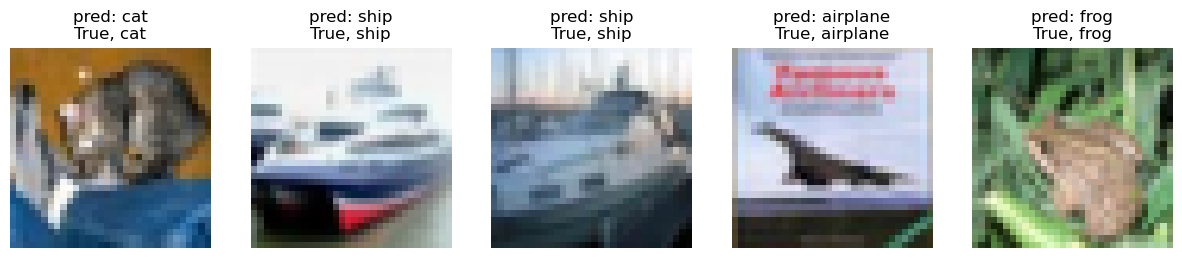

In [13]:
# Define a function to display predictions

def show_predictions(model, test_loader,device, classes, num_images=5):

    model.eval()

    images_shown = 0

    plt.figure(figsize=(15,6))


    with torch.no_grad():

        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)


            outputs = model(images)

            _, preds = torch.max(outputs,1)


            for i in range(images.size(0)):

                if images_shown == num_images:

                    return
                img = images[i].cpu().permute(1,2,0).numpy()

                img = (img - img.min()) / (img.max() - img.min()) # Normalize for better visualization


                plt.subplot(1, num_images, images_shown + 1)

                plt.imshow(img)

                plt.title(f'pred: {classes[preds[i]]}\nTrue, {classes[labels[i]]}')

                plt.axis('off')

                images_shown += 1



# Example class labels for CIFAR-10 (Change if using other dataset)

classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# Run the prediction Visualization

show_predictions(model, test_loader,device, classes, num_images=5)

Save the model Weights

In [14]:
# Save the models state_dict

torch.save(model.state_dict(), 'dog_classifier.pth')

print('Model Weights are saved to' ,'dog_classifier.pth')

Model Weights are saved to dog_classifier.pth


Load the Model Later

In [15]:
# Recreate the model structure

model = CustomNN().to(device)

# Load the weights 

model.load_state_dict(torch.load('dog_classifier.pth', map_location=device))

model.eval()

print('Model Loaded and ready for inference')

Model Loaded and ready for inference
